In [31]:
from importlib import reload
from earthtext.io import io
from earthtext.datamodules import chipmultilabel
from progressbar import progressbar as pbar
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
reload(chipmultilabel)
reload(io)

<module 'earthtext.io.io' from '/home/ubuntu/earth-text/src/earthtext/io/io.py'>

In [32]:
mfile = '/opt/data/california-worldcover-chips-osm-multilabels.parquet'
chips_folder = "/opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips"

In [33]:
cm = chipmultilabel.ChipMultilabelModule(
                            metadata_file = mfile,
                            chips_folder = chips_folder, 
                            get_strlabels = True,
                            batch_size = 4,
                            min_ohe_count = None
     )



2024-04-02 01:54:27.017 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:41 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-04-02 01:54:30.148 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:44 - read train split with 58599 chip files (out of 58690)
2024-04-02 01:54:30.596 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:41 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-02 01:54:31.262 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:44 - read val split with 11822 chip files (out of 11841)
2024-04-02 01:54:31.800 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:41 - checking chip files for test split
100% (13078 of 13078) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-02 01:54:32.499 | INFO     | earth

In [34]:
tr = cm.train_dataloader()

In [35]:
for batch in iter(tr):
    break

In [36]:
{k:len(v) for k,v in batch.items()}

{'chip': 4, 'multilabel': 4, 'str_multilabel': 4}

In [37]:
batch['str_multilabel']

['highway=* highway=residential landuse=* landuse=commercial landuse=farmland landuse=residential natural=* natural=water surface=* surface=paved water=* water=reservoir waterway=* waterway=stream',
 'waterway=* waterway=stream',
 'highway=* highway=residential highway=track',
 'highway=* highway=residential highway=track landuse=* landuse=farmland natural=* natural=scrub natural=water waterway=* waterway=stream']

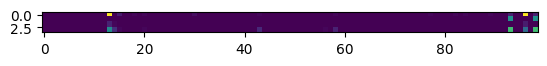

In [38]:
plt.imshow(batch['multilabel'])

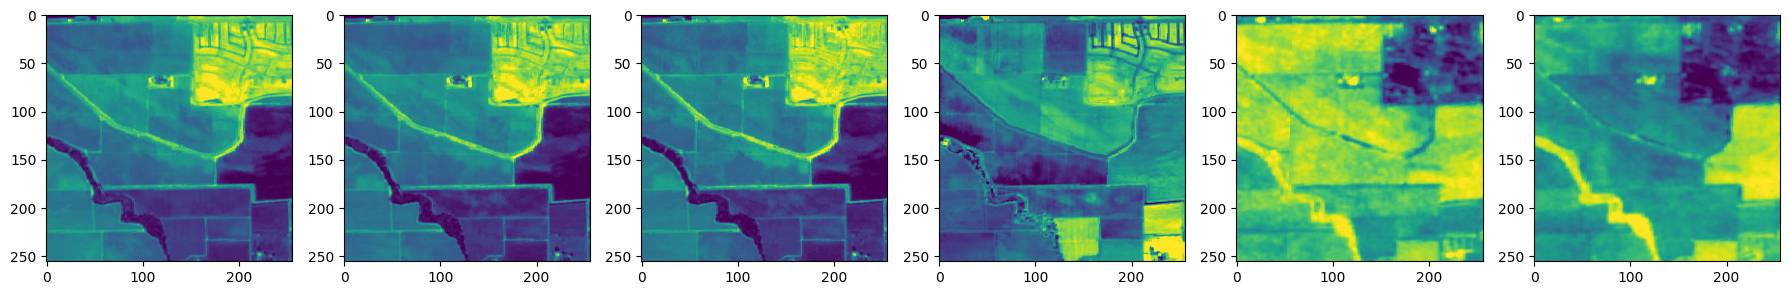

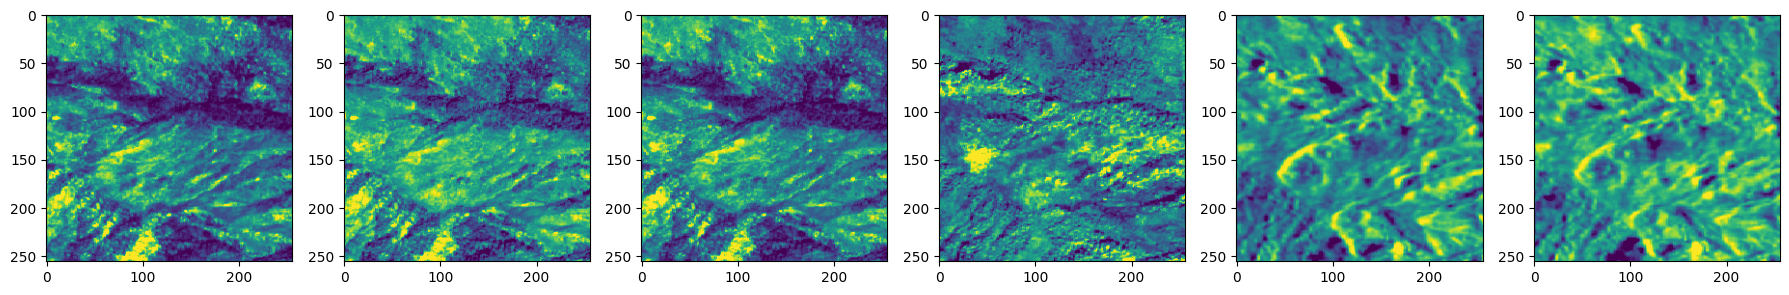

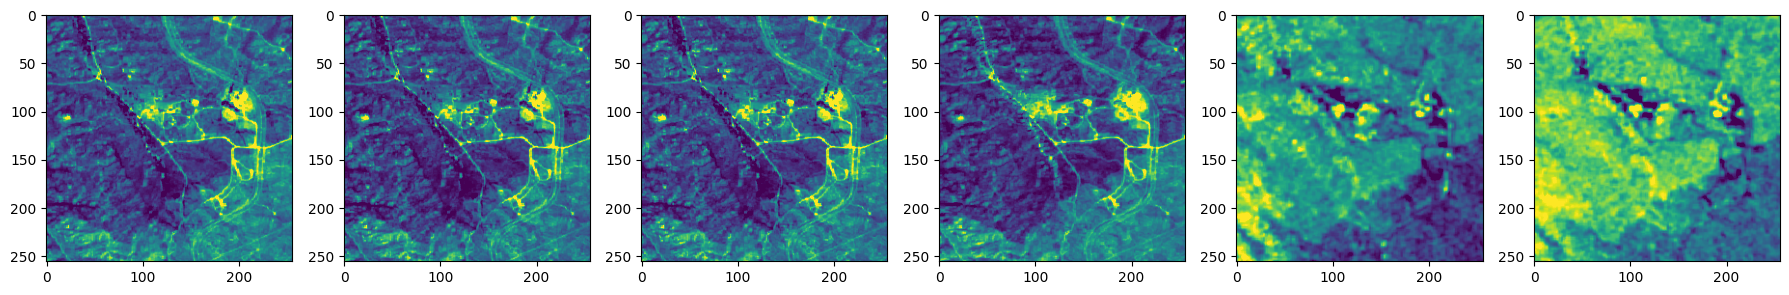

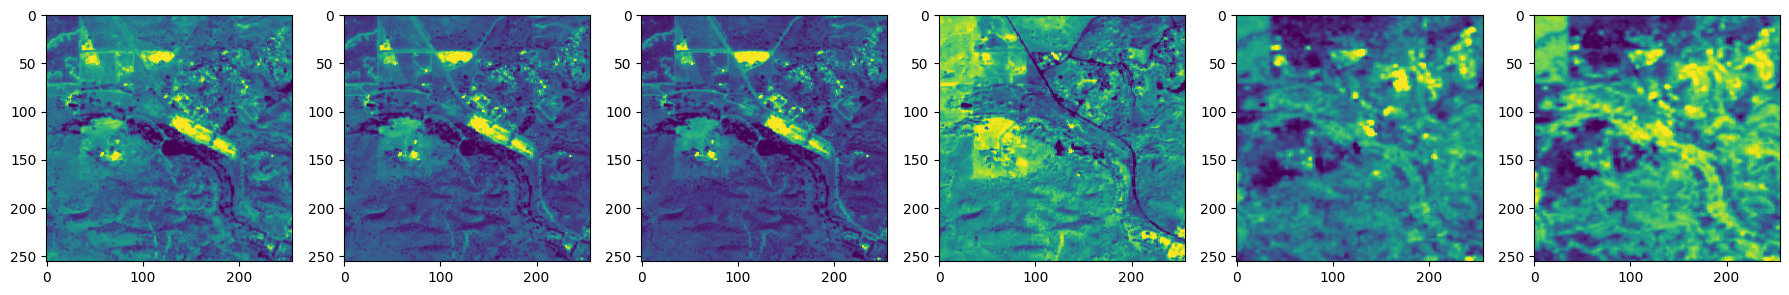

In [39]:
x = batch['chip']
for i in range(len(x)):
    xi = x[i]
    for ax, ii in subplots(len(xi)):
        xii = xi[ii]
        a,b = np.percentile(xii, [1,99])
        plt.imshow(xii, vmin=a, vmax=b)